# GoW_corpus_by_year (W+J)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import spacy
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize
import numpy as np
import re
import pickle
import powerlaw
import string
import itertools
import json
import statistics
import numpy.linalg as la
import scipy.cluster.vq as vq
import random
from collections import Counter
data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

In [2]:
#########################################################################################################################
############################################### progress bar ############################################################
#########################################################################################################################
################################# https://github.com/alexanderkuk/log-progress ##########################################
#########################################################################################################################
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

## funcion que limpia los textos

In [ ]:
def clean(text,noun_adj): 
    text=re.sub("[\(\[].*?[\)\]]", "", text)
    text=text.replace('al.','')
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence.lower()) for sentence in sentences] 
    
    if noun_adj==True:
        sentences=[[token.lemma_ for token in sentence if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ'] for sentence in sentences]
    else:
        sentences=[[token.lemma_ for token in sentence if token.lemma_ != '-PRON-' and token.is_punct==False and token.like_num==False] for sentence in sentences]

    sentences=[[word for word in sentence if not word in stop_words] for sentence in sentences]
    sentences=[[(re.sub(r'[^a-zA-Z0-9]', '', word)) for word in sentence] for sentence in sentences]  
    sentences=[[word for word in sentence if word.isdigit()==False and word!=''] for sentence in sentences]
    sentences=[sentence for sentence in sentences if len(sentence)>1]
    
    return sentences

## ejemplo

In [ ]:
text='Sequencing the Neanderthal genome (Green et al., 2010, Prüfer et al., 2014), the Denisovan genome (Reich et al., 2010), and several early modern human genomes from Eurasia (Fu et al., 2014, Fu et al., 2015) has confirmed that archaic hominins left their mark in the genomes of modern humans (Plagnol and Wall, 2006, Sankararaman et al., 2014, Vernot and Akey, 2014, Vernot et al., 2016). Present-day individuals in Eurasia inherited ∼2% of their genome from Neanderthals (Green et al., 2010), and individuals from Oceania inherited ∼5% of their genome from Denisovans (Reich et al., 2010). Suggestive evidence indicates that admixture from other unidentified hominin species occurred in Africa (Hammer et al., 2011, Hsieh et al., 2016, Lachance et al., 2012, Plagnol and Wall, 2006, Wall et al., 2009). To understand the functional, phenotypic, and evolutionary consequences of archaic admixture, it is necessary to identify the specific haplotypes and alleles that were inherited from archaic hominin ancestors (Huerta-Sánchez et al., 2014, Juric et al., 2016, Sankararaman et al., 2014, Simonti et al., 2016, Vernot and Akey, 2014). Approaches to identifying introgressed haplotypes include methods that specifically incorporate reference archaic hominin genome sequences and reference-free methods that do not utilize such information. An example of the former category is the method of Sankararaman et al. (2014), which identifies archaic haplotypes by comparing modern human haplotypes to a reference archaic sequence. The latter category of methods include the S∗ statistic (Plagnol and Wall, 2006), which searches for the mutational signature that ancient admixture leaves in the genomes of present-day humans. The S∗ approach is powerful for finding introgressed haplotypes in the absence of an archaic reference genome because it leverages the unusual mutational characteristics of introgressed haplotypes. Because of the long divergence time between Neanderthals and modern humans, Neanderthals carry many alleles that are specific to their lineage. Such alleles are present on introgressed haplotypes but are absent or rare in African genomes. Further, based on the recent timing of admixture, introgressed haplotypes are expected to be maintained without recombination over distances of approximately 50 kb on average (Sankararaman et al., 2012), resulting in high levels of linkage disequilibrium (LD) between Neanderthal-specific alleles in non-African human genomes. In this study, we develop an S∗-like method that has increased power and is suitable for large-scale genome-wide data. We apply the method to large sets of sequenced data from Eurasia and Oceania and identify putative archaic-specific alleles. We examine the rate at which these alleles match the sequenced archaic genomes and the role of the genes containing these alleles, to obtain insights into the history of the admixture events and their impact on modern human genomes.'
text_clean=clean(text,True)
text_clean

## grafo de palabras
### https://pdfs.semanticscholar.org/6c5f/e85468b488e5d000b62596d89e313906b733.pdf?_ga=2.78701266.738419600.1525701802-2082719092.1515592461

In [ ]:
def graph(text_clean):
    G=nx.Graph()
    for sentence in text_clean:
        unique_words=list(set(sentence))
        for word in unique_words:
            if word not in G:
                G.add_node(word)
        pairs=list(itertools.combinations(unique_words,2)) ## sin repeticion!
        for pair in pairs:
            if G.has_edge(pair[0],pair[1])==False:
                G.add_edge(pair[0],pair[1],weight=1/float(len(unique_words)-1))
            else:
                x=G[pair[0]][pair[1]]['weight']
                G[pair[0]][pair[1]]['weight']=x+1/float(len(unique_words)-1)  
        
    return G

In [ ]:
G=graph(text_clean)

In [ ]:
G

## experimento corpus introducciones CELL + NEURON

In [ ]:
data_cell = json.load(open('cell_full_xml.json'))
data_neuron =  json.load(open('neuron_full_xml.json'))
data_cell_metabolism= json.load(open('cell_metabolism_full_xml.json'))
data_immunity= json.load(open('immunity_full_xml.json'))
#data_cell=data_cell+data_neuron+data_cell_metabolism+data_immunity

def paragraphs(paper):
    text=[]
    if len(paper['subsections'])==0:
        return ' '.join(paper['paragraphs'])

def extract_intro(paper):
    return paper['sections'][0]

cell=[paragraphs(extract_intro(data_cell[i])) for i in range(len(data_cell)) if len(data_cell[i]['sections'])>1]
cell=[paper for paper in cell if type(paper)!='NoneType']

neuron=[paragraphs(extract_intro(data_neuron[i])) for i in range(len(data_neuron)) if len(data_neuron[i]['sections'])>1]
neuron=[paper for paper in neuron if type(paper)!='NoneType']

## corpus by year!

### cell 

In [ ]:
dois=[data_cell[i]['doi'][19:23] for i in range(len(data_cell))]
keys_doi=list(set(dois))
keys_doi=[k for k in keys_doi if k!='2009' and k!='2017']

In [ ]:
doi_dict={}
for key in keys_doi:
    doi_dict[key]=[]

In [ ]:
for i in range(len(data_cell)):
    for key in keys_doi:
        if data_cell[i]['doi'][19:23]==key:
            if len(data_cell[i]['sections'])>0:
                paper=paragraphs(extract_intro(data_cell[i]))
                if type(paper)!='NoneType':
                    doi_dict[key]+=[paper]

In [ ]:
suma=0
for key in keys_doi:
    print(key,len(doi_dict[key]))
    suma+=len(doi_dict[key])
print(suma)

### neuron

In [ ]:
dois_neuron=[data_neuron[i]['doi'][21:25] for i in range(len(data_neuron))]
keys_doi_neuron=list(set(dois_neuron))
keys_doi_neuron=[k for k in keys_doi_neuron if k!='2009' and k!='2017']

In [ ]:
doi_dict_neuron={}
for key in keys_doi_neuron:
    doi_dict_neuron[key]=[]

In [ ]:
for i in range(len(data_neuron)):
    for key in keys_doi_neuron:
        if data_neuron[i]['doi'][21:25]==key:
            if len(data_neuron[i]['sections'])>0:
                paper=paragraphs(extract_intro(data_neuron[i]))
                if type(paper)!='NoneType':
                    doi_dict_neuron[key]+=[paper]

In [ ]:
suma=0
for key in keys_doi_neuron:
    print(key,len(doi_dict_neuron[key]))
    suma+=len(doi_dict_neuron[key])
print(suma)

## clean a los documentos de los diccionarios de cell y neuron

### cell

In [ ]:
text_cell={}
for key in keys_doi:
    text_cell[key]=[]

In [ ]:
for key in log_progress(keys_doi, every=1):
    for text in doi_dict[key]:
        try:
            text_cell[key]+=clean(text,True)
        except TypeError:
            pass

In [ ]:
for key in keys_doi:
    text_cell[key]=[text for text in text_cell[key] if len(text)>1]

In [ ]:
for key in keys_doi:
    print(key,len(text_cell[key]))

### neuron

In [ ]:
text_neuron={}
for key in keys_doi_neuron:
    text_neuron[key]=[]

In [ ]:
for key in log_progress(keys_doi_neuron, every=1):
    for text in doi_dict_neuron[key]:
        try:
            text_neuron[key]+=clean(text,True)
        except TypeError:
            pass

In [ ]:
for key in keys_doi_neuron:
    text_neuron[key]=[text for text in text_neuron[key] if len(text)>1]

In [ ]:
for key in keys_doi_neuron:
    print(key,len(text_neuron[key]))

## grafos by year para cada revista

### cell

In [ ]:
graphs={}
for key in log_progress(keys_doi, every=1):
    graphs[key]=graph(text_cell[key])

In [ ]:
pickle.dump(graphs,open( 'graphs_cell.p', 'wb' ) )

In [ ]:
##########################################################################################################################

In [3]:
keys_doi=['2010','2011','2012','2013','2014','2015','2016']

In [4]:
graphs = pickle.load(open( 'graphs_cell.p', 'rb' ) )

In [5]:
for key in keys_doi:
    G=graphs[key]
    print(key)
    print('nodes: '+str(len(G.nodes)))
    print('edges: '+str(len(G.edges)))
    print('average degree: '+str(sum(dict(nx.degree(G,weight='weight')).values())/float(len(G.nodes))))
    print('max degree: '+str(max(dict(nx.degree(G,weight='weight')).values())))
    core_number=nx.core_number(G)
    print('max core number: '+str(max(core_number.values())))
    main_core=nx.k_core(G)
    print('main core size: '+str(len(main_core)))

2010
nodes: 6567
edges: 187559
average degree: 7.674889599512717
max degree: 951.0000000000055
max core number: 97
main core size: 249
2011
nodes: 7103
edges: 221887
average degree: 8.305504716317047
max degree: 1126.9999999999973
max core number: 110
main core size: 297
2012
nodes: 8096
edges: 277817
average degree: 9.574851778656122
max degree: 1435.9999999999638
max core number: 132
main core size: 328
2013
nodes: 8024
edges: 264346
average degree: 9.090603190428709
max degree: 1308.999999999975
max core number: 123
main core size: 336
2014
nodes: 8146
edges: 282394
average degree: 9.391112202307871
max degree: 1496.9999999999673
max core number: 129
main core size: 347
2015
nodes: 8539
edges: 302790
average degree: 9.448998711792942
max degree: 1515.999999999974
max core number: 132
main core size: 431
2016
nodes: 7801
edges: 266902
average degree: 8.94923727727214
max degree: 1381.9999999999766
max core number: 126
main core size: 373


### neuron

In [ ]:
graphs_neuron={}
for key in log_progress(keys_doi_neuron, every=1):
    graphs_neuron[key]=graph(text_neuron[key])

In [ ]:
pickle.dump(graphs_neuron,open( 'graphs_neuron.p', 'wb' ) )

In [ ]:
#########################################################################################################################

In [5]:
keys_doi_neuron=['2010','2011','2012','2013','2014','2015','2016']

In [6]:
graphs_neuron = pickle.load(open( 'graphs_neuron.p', 'rb' ) )

In [8]:
for key in keys_doi_neuron:
    G=graphs_neuron[key]
    print(key)
    print('nodes: '+str(len(G.nodes)))
    print('edges: '+str(len(G.edges)))
    print('average degree '+str(sum(dict(nx.degree(G,weight='weight')).values())/float(len(G.nodes))))
    print('max degree '+str(max(dict(nx.degree(G,weight='weight')).values())))
    core_number=nx.core_number(G)
    print('max core number '+str(max(core_number.values())))
    main_core=nx.k_core(G)
    print('main core size: '+str(len(main_core)))

2010
nodes: 4704
edges: 154225
average degree 8.494472789115646
max degree 649.0000000000018
max core number 102
main core size: 219
2011
nodes: 5973
edges: 217627
average degree 10.061443160890674
max degree 1012.000000000005
max core number 123
main core size: 289
2012
nodes: 5541
edges: 195364
average degree 9.436022378632012
max degree 669.0000000000011
max core number 116
main core size: 278
2013
nodes: 5869
edges: 202962
average degree 9.625830635542682
max degree 898.0000000000041
max core number 117
main core size: 287
2014
nodes: 6129
edges: 225788
average degree 10.173274596182084
max degree 880.0000000000008
max core number 124
main core size: 372
2015
nodes: 5418
edges: 197626
average degree 10.137135474344774
max degree 862.0000000000052
max core number 121
main core size: 292
2016
nodes: 5945
edges: 228288
average degree 10.585029436501259
max degree 976.0000000000026
max core number 128
main core size: 352


## k core decomposition by year

### cell

In [9]:
k_core_decomposition={}
for key in keys_doi:
    k_core_decomposition[key]=[]
    
for key in log_progress(keys_doi, every=1):
    G=graphs[key]
    core_numbers=list(set(nx.core_number(G).values()))
    m=len(core_numbers)
    K=[1]
    for i in range(5):
        K+=[core_numbers[m-i*15-1]]
    K=sorted(K)
    for k in K: ## elegimos 6!
        k_core_decomposition[key]+=[(k,nx.k_core(G,k=k))]

A Jupyter Widget

In [10]:
k_core_decomposition['2016']

[(1, <networkx.classes.graph.Graph at 0x7f75af21a780>),
 (66, <networkx.classes.graph.Graph at 0x7f75af21a550>),
 (81, <networkx.classes.graph.Graph at 0x7f75af21a198>),
 (96, <networkx.classes.graph.Graph at 0x7f75af21a3c8>),
 (111, <networkx.classes.graph.Graph at 0x7f75a6727c50>),
 (126, <networkx.classes.graph.Graph at 0x7f75af21a080>)]

### neuron

In [11]:
k_core_decomposition_neuron={}
for key in keys_doi_neuron:
    k_core_decomposition_neuron[key]=[]
    
for key in log_progress(keys_doi_neuron, every=1):
    G=graphs_neuron[key]
    core_numbers=list(set(nx.core_number(G).values()))
    m=len(core_numbers)
    K=[1]
    for i in range(5):
        K+=[core_numbers[m-i*15-1]]
    K=sorted(K)
    for k in K: 
        k_core_decomposition_neuron[key]+=[(k,nx.k_core(G,k=k))]

A Jupyter Widget

In [12]:
k_core_decomposition_neuron['2016']

[(1, <networkx.classes.graph.Graph at 0x7f75563b9898>),
 (68, <networkx.classes.graph.Graph at 0x7f75563b9ac8>),
 (83, <networkx.classes.graph.Graph at 0x7f75563b98d0>),
 (98, <networkx.classes.graph.Graph at 0x7f75563b9b38>),
 (113, <networkx.classes.graph.Graph at 0x7f75563b9e80>),
 (128, <networkx.classes.graph.Graph at 0x7f75563b9b00>)]

## degree distribution para distintos k core

### cell

In [13]:
degree_sequence={}
for key in keys_doi:
    degree_sequence[key]=[]

for key in log_progress(keys_doi,every=1):
    degree=[]
    for graph in list(zip(*k_core_decomposition[key]))[1]:
        d=list(dict(nx.degree(graph,weight='weight')).values())
        d=[x/float(np.mean(d)) for x in sorted(d)]
        degree+=[(d,[x/float(max(np.cumsum(d))) for x in sorted(list(np.cumsum(d)),reverse=True)])]
    degree_sequence[key]=degree


A Jupyter Widget

In [14]:
labels=sorted(list(zip(*k_core_decomposition['2016']))[0])

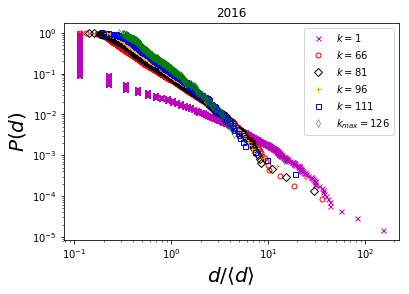

In [15]:
plt.plot(degree_sequence['2016'][0][0],degree_sequence['2016'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence['2016'][1][0],degree_sequence['2016'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence['2016'][2][0],degree_sequence['2016'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence['2016'][3][0],degree_sequence['2016'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence['2016'][4][0],degree_sequence['2016'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence['2016'][5][0],degree_sequence['2016'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2016')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_2016.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [16]:
labels=sorted(list(zip(*k_core_decomposition['2013']))[0])

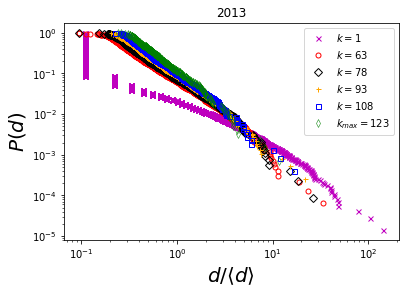

In [17]:
plt.plot(degree_sequence['2013'][0][0],degree_sequence['2013'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence['2013'][1][0],degree_sequence['2013'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence['2013'][2][0],degree_sequence['2013'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence['2013'][3][0],degree_sequence['2013'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence['2013'][4][0],degree_sequence['2013'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence['2013'][5][0],degree_sequence['2013'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2013')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_2013.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [18]:
labels=sorted(list(zip(*k_core_decomposition['2010']))[0])

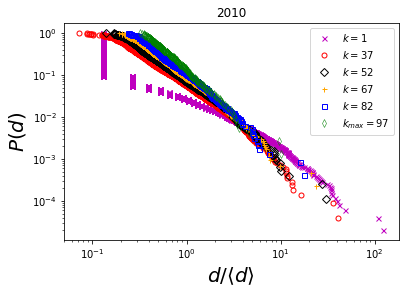

In [19]:
plt.plot(degree_sequence['2010'][0][0],degree_sequence['2010'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence['2010'][1][0],degree_sequence['2010'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence['2010'][2][0],degree_sequence['2010'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence['2010'][3][0],degree_sequence['2010'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence['2010'][4][0],degree_sequence['2010'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence['2010'][5][0],degree_sequence['2010'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2010')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_2010.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

### neuron

In [20]:
degree_sequence_neuron={}
for key in keys_doi_neuron:
    degree_sequence_neuron[key]=[]

for key in log_progress(keys_doi_neuron,every=1):
    degree_neuron=[]
    for graph in list(zip(*k_core_decomposition_neuron[key]))[1]:
        d=list(dict(nx.degree(graph,weight='weight')).values())
        d=[x/float(np.mean(d)) for x in sorted(d)]
        degree_neuron+=[(d,[x/float(max(np.cumsum(d))) for x in sorted(list(np.cumsum(d)),reverse=True)])]
    degree_sequence_neuron[key]=degree_neuron

A Jupyter Widget

In [21]:
labels=sorted(list(zip(*k_core_decomposition_neuron['2016']))[0])

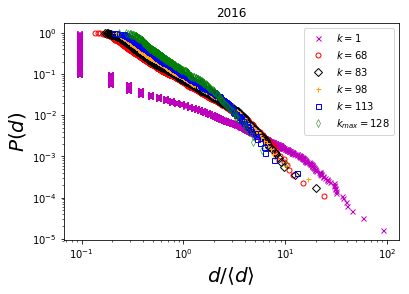

In [22]:
plt.plot(degree_sequence_neuron['2016'][0][0],degree_sequence_neuron['2016'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence_neuron['2016'][1][0],degree_sequence_neuron['2016'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence_neuron['2016'][2][0],degree_sequence_neuron['2016'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence_neuron['2016'][3][0],degree_sequence_neuron['2016'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence_neuron['2016'][4][0],degree_sequence_neuron['2016'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence_neuron['2016'][5][0],degree_sequence_neuron['2016'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2016')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_neuron_2016.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [23]:
labels=sorted(list(zip(*k_core_decomposition_neuron['2013']))[0])

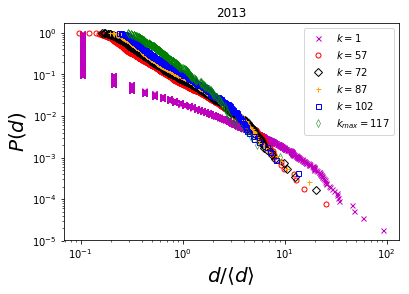

In [24]:
plt.plot(degree_sequence_neuron['2013'][0][0],degree_sequence_neuron['2013'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence_neuron['2013'][1][0],degree_sequence_neuron['2013'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence_neuron['2013'][2][0],degree_sequence_neuron['2013'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence_neuron['2013'][3][0],degree_sequence_neuron['2013'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence_neuron['2013'][4][0],degree_sequence_neuron['2013'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence_neuron['2013'][5][0],degree_sequence_neuron['2013'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2013')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_neuron_2013.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [25]:
labels=sorted(list(zip(*k_core_decomposition_neuron['2010']))[0])

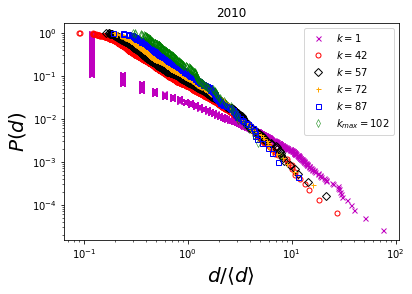

In [26]:
plt.plot(degree_sequence_neuron['2010'][0][0],degree_sequence_neuron['2010'][0][1],'m',marker='x',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[0]))
plt.plot(degree_sequence_neuron['2010'][1][0],degree_sequence_neuron['2010'][1][1],'r',marker='o',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[1]))
plt.plot(degree_sequence_neuron['2010'][2][0],degree_sequence_neuron['2010'][2][1],'k',marker='D',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[2]))
plt.plot(degree_sequence_neuron['2010'][3][0],degree_sequence_neuron['2010'][3][1],'orange',marker='+',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[3]))
plt.plot(degree_sequence_neuron['2010'][4][0],degree_sequence_neuron['2010'][4][1],'b',marker='s',markersize=5,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=0,label=r'$k=$'+str(labels[4]))
plt.plot(degree_sequence_neuron['2010'][5][0],degree_sequence_neuron['2010'][5][1],'green',marker='d',markersize=5,fillstyle='none',markeredgewidth=0.5,clip_on=False,linewidth=0,label=r'$k_{max}=$'+str(labels[5]))

plt.title('2010')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylabel(r'$P(d)$',fontsize=20)
plt.xlabel(r'$d/ \langle d \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('degree_distribution_neuron_2010.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## power law parameter

### cell + neuron kmax

In [27]:
alpha_cell=[]
for key in keys_doi:
    alpha_cell+=[powerlaw.Fit(degree_sequence[key][5][1],xmin=0.25).alpha]

In [28]:
alpha_neuron=[]
for key in keys_doi_neuron:
    alpha_neuron+=[powerlaw.Fit(degree_sequence_neuron[key][5][1],xmin=0.25).alpha]

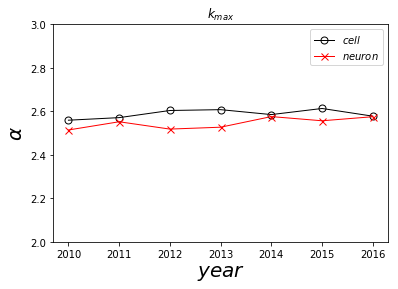

In [29]:
plt.plot(keys_doi,alpha_cell,'k',marker='o',markersize=7,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=1,label=r'$cell$')
plt.plot(keys_doi_neuron,alpha_neuron,'r',marker='x',markersize=7,fillstyle='none',markeredgewidth=1,clip_on=False,linewidth=1,label=r'$neuron$')

plt.title(r'$k_{max}$')
plt.legend(loc='best')
plt.ylabel(r'$ \alpha$',fontsize=20)
plt.xlabel(r'$year$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.ylim(2,3)
plt.savefig('alpha.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## alpha para multiples k

### cell + neuron

In [36]:
k_core_decomposition_multiple={}
for key in keys_doi:
    k_core_decomposition_multiple[key]=[]
    
for key in log_progress(keys_doi, every=1):
    G=graphs[key]
    core_numbers=list(set(nx.core_number(G).values()))
    K=core_numbers[len(core_numbers)-20:]
    for k in K: 
        k_core_decomposition_multiple[key]+=[(k,nx.k_core(G,k=k))]

A Jupyter Widget

In [37]:
k_core_decomposition_neuron_multiple={}
for key in keys_doi_neuron:
    k_core_decomposition_neuron_multiple[key]=[]
    
for key in log_progress(keys_doi_neuron, every=1):
    G=graphs_neuron[key]
    core_numbers=list(set(nx.core_number(G).values()))
    K=core_numbers[len(core_numbers)-20:]
    for k in K: 
        k_core_decomposition_neuron_multiple[key]+=[(k,nx.k_core(G,k=k))]

A Jupyter Widget

In [ ]:
degree_sequence_multiple={}
for key in keys_doi:
    degree_sequence_multiple[key]=[]

for key in log_progress(keys_doi,every=1):
    degree=[]
    for graph in list(zip(*k_core_decomposition_multiple[key]))[1]:
        d=list(dict(nx.degree(graph,weight='weight')).values())
        d=[x/float(np.mean(d)) for x in sorted(d)]
        degree+=[(d,[x/float(max(np.cumsum(d))) for x in sorted(list(np.cumsum(d)),reverse=True)])]
    degree_sequence_multiple[key]=degree

A Jupyter Widget

In [27]:
degree_sequence_neuron_multiple={}
for key in keys_doi_neuron:
    degree_sequence_neuron_multiple[key]=[]

for key in log_progress(keys_doi_neuron,every=1):
    degree=[]
    for graph in list(zip(*k_core_decomposition_neuron_multiple[key]))[1]:
        d=list(dict(nx.degree(graph,weight='weight')).values())
        d=[x/float(np.mean(d)) for x in sorted(d)]
        degree+=[(d,[x/float(max(np.cumsum(d))) for x in sorted(list(np.cumsum(d)),reverse=True)])]
    degree_sequence_neuron_multiple[key]=degree

A Jupyter Widget

In [28]:
alpha_cell_dict={}
for key in keys_doi:
    alpha_cell_dict[key]=[]

for key in keys_doi:
    for i in range(len(degree_sequence_multiple[key])):
        alpha_cell_dict[key]+=[powerlaw.Fit(degree_sequence_multiple[key][i][1],xmin=0.25).alpha]

In [29]:
alpha_neuron_dict={}
for key in keys_doi_neuron:
    alpha_neuron_dict[key]=[]

for key in keys_doi_neuron:
    for i in range(len(degree_sequence_neuron_multiple[key])):
        alpha_neuron_dict[key]+=[powerlaw.Fit(degree_sequence_neuron_multiple[key][i][1],xmin=0.25).alpha]

In [30]:
for key in keys_doi:
    mean=np.mean(alpha_cell_dict[key])
    std=np.std(alpha_cell_dict[key])
    alpha_cell_dict[key]=[mean,std]

In [31]:
for key in keys_doi_neuron:
    mean_neuron=np.mean(alpha_neuron_dict[key])
    std_neuron=np.std(alpha_neuron_dict[key])
    alpha_neuron_dict[key]=[mean_neuron,std_neuron]

In [32]:
Y=list(zip(*alpha_cell_dict.values()))[0]
e=list(zip(*alpha_cell_dict.values()))[1]

In [33]:
Y_neuron=list(zip(*alpha_neuron_dict.values()))[0]
e_neuron=list(zip(*alpha_neuron_dict.values()))[1]

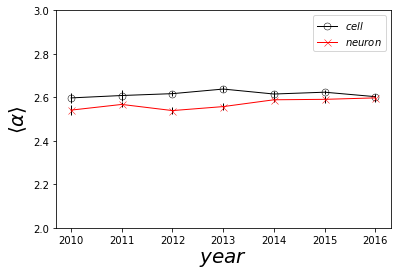

In [35]:
plt.plot(keys_doi,Y,'k',fillstyle='none',marker='o',markersize=7,markeredgewidth=0.5,clip_on=False,linewidth=1,label=r'$cell$')
plt.errorbar(keys_doi,Y,e, linestyle='None', fillstyle='none',linewidth=1,markeredgewidth=0,clip_on=False,color='k')
plt.plot(keys_doi_neuron,Y_neuron,'r',fillstyle='none',marker='x',markersize=7,markeredgewidth=0.5,clip_on=False,linewidth=1,label=r'$neuron$')
plt.errorbar(keys_doi_neuron,Y_neuron,e_neuron, linestyle='None', fillstyle='none',linewidth=1,markeredgewidth=0,clip_on=False,color='k')

plt.ylim(2,3)
plt.legend(loc='best')
plt.ylabel(r'$\langle \alpha \rangle$',fontsize=20)
plt.xlabel(r'$year$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('alpha_mean_std.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
plt.show()